# Kinetic Hypothesis Testing Using KineticAI Package | Example #2 
In this notebook, we will go over:  
1.   How to initilize reactions system in KineticAI
2.   How to simulate a system of ODEs for a given reaction mechanism 
3.   How to visualize the KineticAI ODE solver and plot them against experimental data
4.   How to run a bayesain regression for a testing a hyptothesis based on expeirmental data 
5.  How to define multiple reaction systems and compare and rank the model


**Authored by:**  Xiao Li, Reza Amirmoshiri, Yasser Jangjou
@ Sanofi CMC synthetics 

**Reactions:**

$$
\begin{align*}
  R1. & \;\; \text{Starting Material + Base + Reagent} \rightarrow \text{Product + Base} \\
  R2. & \;\; \text{Product + Base + Reagent} \rightarrow \text{Impurity + Base}
\end{align*}
$$
**Rate Equations:**
$$
\begin{align*}
  R_{1f} & = k_{1f} \times e^{(-E_{1f}/RT)} \times C^m_{\text{starting material}} \times C^n_{\text{reagent}}  \times C^p_{\text{base}}\\
  R_{2f} & = k_{2f} \times e^{(-E_{2f}/RT)} \times C^m_{\text{product}} \times C^n_n{\text{reagent}}   \times C^p_{\text{base}}
\end{align*}
$$

</div>



In [1]:
import jax.numpy as jnp
import pandas as pd
import arviz as az 
import numpyro
import numpyro.distributions as dist
import jax
import matplotlib.pyplot as plt
import seaborn as sns



# KineticAI imports 

# symbolic ODE solver from KineticAI 
from KineticAI.utilities.reaction_solver import SymbolicRXNSolver

# bayesian inference from KineticAI
from KineticAI.models.Inference import BayesianKineticAI



## Section 1. Import initial conditions & fitted parameters using an ODE solver (Dynochem)

In [2]:
 
# define the initial conditions

                 # T  SM_0   R_0   B_0 
X1 = jnp.array([81.9, 0.208, 0.2, 0.405])
X2 = jnp.array([81.9, 0.203, 0.4, 0.405])
X3 = jnp.array([81.9, 0.204, 0.2, 0.811])
X4 = jnp.array([61.1, 0.209, 0.2, 0.406])
X5 = jnp.array([71.0, 0.209, 0.2, 0.407])

X1 = jnp.reshape(X1, (4, 1))
X2 = jnp.reshape(X2, (4, 1))
X3 = jnp.reshape(X3, (4, 1))
X4 = jnp.reshape(X4, (4, 1))
X5 = jnp.reshape(X5, (4, 1))

input_matrix = jnp.concatenate([X1, X2, X3, X4, X5], axis=1)

time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 540.0, 600.0, 780.0, 900.0, 960.0, 1207.0, 1374.0])


ground_truth_params = {
"k1_f": 0.011,
"E1_f": 70.2E3,   
"k2_f": 0.002,
"E2_f": 78.92E3,
}


    #   E1_f     11.30      0.03     11.30     11.26     11.35    198.15      1.00
    #   E2_f     11.41      0.19     11.46     11.17     11.60    244.69      1.01
    #   k1_f      4.46      0.02      4.46      4.43      4.50    233.74      1.01
    #   k2_f      6.05      0.07      6.05      5.93      6.17    292.57      1.00
mean_params = {
"k1_f": jnp.exp(-4.46),
"E1_f": jnp.exp(10.85 ),
"k2_f": jnp.exp(-6.01),
"E2_f": jnp.exp(10.84),
}

mean_params2 = {
"k1_f": jnp.exp(-4.46),
"E1_f": jnp.exp(11.30 ),
"k2_f": jnp.exp(-6.01),
"E2_f": jnp.exp(11.41-0.19),
}


## Section 2. Define reaction system in SKAI

In [3]:
# Mechanism #1
# R1.    SM + B + R -> P + B,  
# R2.    P + B +  R -> IMP2 + B

reactions_example_1 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1, 'base': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': {'SM':1, 'reagent': 1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1 = SymbolicRXNSolver(reactions_example_1)
reaction1.reaction_table()



reactions_exp = reaction1.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

ode_expressions = reaction1.write_ODE_system()
for species in ode_expressions[0]:
    equation_str = ode_expressions[0][species]
    print(equation_str)

Reaction:

+----------+-----------------------------+-----+------------------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products         | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+------------------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product + 1base | 0.01  | 70000.0 | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1            | 0.002 | 78000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+------------------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^1 reagent^1 base^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * product^1 reagent^1 base^1', 'backward': ''})
dIMP1/dt = 0 + 1 * Rate_rxn2_forward
dproduct/dt = 1 * Rate_rxn1_forward + -1 * Rate_rxn2_forward
dSM/dt = -1 * Rate_rxn1_

In [4]:
# Mechanism #1
# R1.  SM + B + R -> P + B
# R2.  SM + P + B -> IMP2 + B


reactions_example_2 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1, 'base':1},
        'k_f': 0.1,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': {'SM':1, 'reagent': 1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {
        'reactants': {'SM': 1, 'product': 1, 'base':1},
        'products': {'IMP2': 1, 'base':1},
        'k_f': 0.002,
        'E_f': 77E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'SM':1, 'product': 1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}


reaction2 = SymbolicRXNSolver(reactions_example_2)
reaction2.reaction_table()

reactions_exp = reaction2.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

ode_expressions = reaction2.write_ODE_system()
for species in ode_expressions[0]:
    equation_str = ode_expressions[0][species]
    print(equation_str)

Reaction:

+----------+------------------------+-----+------------------+-------+---------+-------+-------+-------------+
| Reaction | Reactants              |     | Products         | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+------------------------+-----+------------------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base | --> | 1product + 1base | 0.1   | 70000.0 | 0     | 0     | False       |
| rxn2     | 1SM + 1product + 1base | --> | 1IMP2 + 1base    | 0.002 | 77000.0 | 0     | 0     | False       |
+----------+------------------------+-----+------------------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^1 reagent^1 base^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * SM^1 product^1 base^1', 'backward': ''})
dproduct/dt = 1 * Rate_rxn1_forward + -1 * Rate_rxn2_forward
dSM/dt = -1 * Rate_rxn1_forward + -1 * Rate_rxn2_forward
dreagent/dt = -1 * Rate_rxn1_forward + 

In [5]:
# mechanism 3
# R1.  SM + B + R -> P + B + INT1  
# R2.   B + INT1 -> P + B

reactions_example_3 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'INT1': 1, 'base':1, 'product':1},
        'k_f': 0.1,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': {'SM':1, 'reagent': 1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {
        'reactants': {'base': 1, 'INT1':1},
        'products': {'IMP2': 1, 'product':1},
        'k_f': 0.002,
        'E_f': 77E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'base': 1, 'INT1':1},
        'Rxn_orders_b': '', 
        
    }
}
reaction3 = SymbolicRXNSolver(reactions_example_3)
reaction3.reaction_table()


reactions_exp = reaction3.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

ode_expressions = reaction3.write_ODE_system()
for species in ode_expressions[0]:
    equation_str = ode_expressions[0][species]
    print(equation_str)

Reaction:

+----------+------------------------+-----+--------------------------+-------+---------+-------+-------+-------------+
| Reaction | Reactants              |     | Products                 | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+------------------------+-----+--------------------------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base | --> | 1INT1 + 1base + 1product | 0.1   | 70000.0 | 0     | 0     | False       |
| rxn2     | 1base + 1INT1          | --> | 1IMP2 + 1product         | 0.002 | 77000.0 | 0     | 0     | False       |
+----------+------------------------+-----+--------------------------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^1 reagent^1 base^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * base^1 INT1^1', 'backward': ''})
dproduct/dt = 1 * Rate_rxn1_forward + 1 * Rate_rxn2_forward
dINT1/dt = 1 * Rate_rxn1_forward + -1 * Rate_rxn2_forward

## Section 2. Kinetic hypothesis testing


### Step 1. Define initial conditions & import experimental data

In [6]:
# experimental data
df_raw = pd.read_csv("example_2_experimental_data2.csv")

# initial conditions
input_data_for_case_study_1 = pd.read_csv('Initial_conditions_example2.csv').to_dict(orient='list')
input_data_for_case_study_1.keys()

dict_keys(['T', 'SM', 'base', 'reagent', 'time'])

In [7]:
# Reading intial conditions and put them into a jnp array as the main input "X_measured" 

T              = jnp.array(input_data_for_case_study_1['T'])
SM             = jnp.array(input_data_for_case_study_1['SM'])
reagent        = jnp.array(input_data_for_case_study_1['reagent'])
base           = jnp.array(input_data_for_case_study_1['base'])
time           = jnp.array(input_data_for_case_study_1['time'])


X_measured     = jnp.column_stack((T, SM, reagent, base, time))

In [8]:
# Preparing the experimental data and save them in a 1D array as y_exp_data 
import numpy as np 
SM_measured = []
P_measured = []
IMP_measured = []

for i in range(0, 5):
    SM_measured.append(df_raw.iloc[:, i * 4 + 1])
    P_measured.append(df_raw.iloc[:, i * 4 + 2])
    IMP_measured.append(df_raw.iloc[:, i * 4 + 3])


non_nan_values_SM  = np.concatenate(SM_measured)
non_nan_values_P   = np.concatenate(P_measured)
non_nan_values_IMP = np.concatenate(IMP_measured)


# # Calculate the measured_Y_without_Nan using non-NaN values arrays   
# ******NOTE ******this is where we apply weighting factor
# measured_Y_without_Nan =  non_nan_values_P +  non_nan_values_IMP
measured_Y_without_Nan = 0.8* non_nan_values_P + 0.1*non_nan_values_SM + 0.1*non_nan_values_IMP
nan_mask = jnp.isnan(measured_Y_without_Nan)
y_without_nan = measured_Y_without_Nan[~nan_mask]

# adding noise
noise_level = 0.0001
noise = np.random.normal(0, noise_level, y_without_nan.shape)
y_exp_data = y_without_nan + noise
X_dummy = X_measured
Y_dummy = y_exp_data
 

### Step 2. Hypothesis testing using Bayesian Inference

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


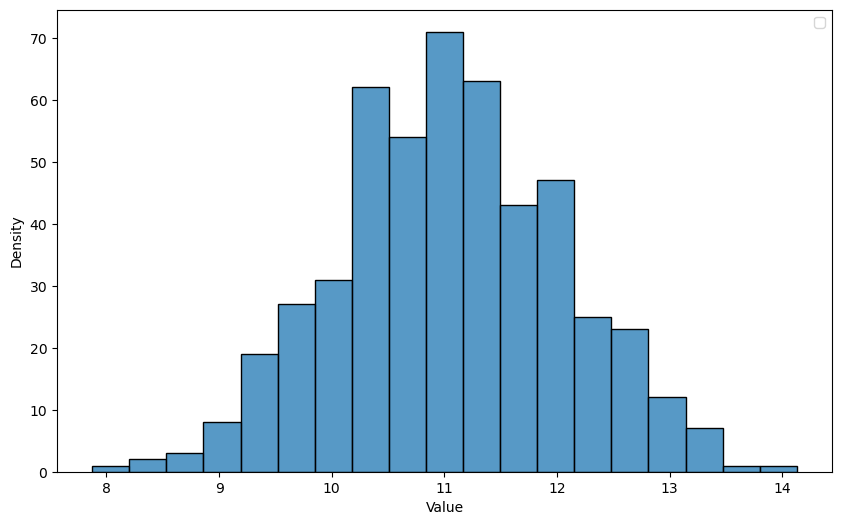

In [9]:


numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_validation()
jax.random.PRNGKey(42)
mu = 0
sigma = 1


# Generate samples from the LogNormal distribution
distribution_ = dist.Normal(11, 1)
# distribution_ = dist.TruncatedNormal(11, 1, low=10, high=11.6)
# # distribution_  = dist.LogNormal(2.3, 0.1).expand_by([1]).to_event(1).mask(False)
num_samples = 500
# Sample from the distribution
samples =  distribution_.sample(jax.random.PRNGKey(123), (num_samples,))


fig = plt.figure(figsize=(10, 6))
sns.histplot(samples)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [10]:
def _new_priors():
    k1_f = numpyro.sample("k1_f", dist.LogNormal(0, 1))
    E1_f = numpyro.sample("E1_f", dist.Normal(10, 1)) 
    k2_f = numpyro.sample("k2_f", dist.LogNormal(0, 1))
    E2_f = numpyro.sample("E2_f", dist.Normal(10, 1))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

In [11]:
t = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 540.0, 900.0])
initial_species = ['SM', 'reagent', 'base']


In [12]:
#### NOTE: make sure Acq function weights are similar to ones used to calculate Y_dummy!

In [14]:
out = reaction1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.1,0.9])


5
['SM', 'reagent', 'base', 'IMP1', 'product']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'IMP1': 3, 'product': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'IMP1': 0.1, 'product': 0.9}


In [15]:
BI_reaction1 = BayesianKineticAI()
BI_model = BI_reaction1.run_bayesian_inference(function = reaction1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[48:], 
    Y= Y_dummy[48:], 
    num_samples=2000,
    num_warmup=1000)

sample: 100%|██████████| 3000/3000 [00:21<00:00, 141.76it/s, 68 steps of size 1.36e-02. acc. prob=0.80] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f      8.90      1.07      8.27      7.60     10.52      5.53      1.04
      E2_f      9.93      1.20      9.80      8.22     11.97      6.76      1.00
      k1_f      4.43      0.21      4.53      4.19      4.59      6.16      1.10
      k2_f      6.35      0.67      6.36      5.53      7.37      5.20      1.01
     sigma      0.00      0.00      0.00      0.00      0.00     23.66      1.00

Number of divergences: 1949


In [ ]:
#### NOTE: make sure Acq function weights are similar to ones used to calculate Y_dummy!

In [16]:
out2 = reaction2.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])


5
['SM', 'reagent', 'base', 'product', 'IMP2']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'IMP2': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'IMP2': 0.1}


In [17]:
BI_reaction2 = BayesianKineticAI()
BI_model2 = BI_reaction2.run_bayesian_inference(function = reaction2.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[48:], 
    Y= Y_dummy[48:], 
    num_samples=2000,
    num_warmup=1000)

sample: 100%|██████████| 3000/3000 [00:18<00:00, 158.18it/s, 5 steps of size 1.25e-02. acc. prob=0.78]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f     10.24      1.02     10.65      8.48     11.47      5.11      1.02
      E2_f     10.82      0.85     10.83      9.67     12.52      6.13      1.40
      k1_f      4.13      0.31      4.10      3.75      4.54      5.63      1.00
      k2_f      5.99      0.87      6.23      4.58      7.18      6.82      1.19
     sigma      0.00      0.00      0.00      0.00      0.00     32.09      1.04

Number of divergences: 1945


#### NOTE: make sure Acq function weights are similar to ones used to calculate Y_dummy!

In [23]:
out3 = reaction3.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0, 0.1])

5
['SM', 'reagent', 'base', 'product', 'INT1', 'IMP2']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'INT1': 4, 'IMP2': 5}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'INT1': 0, 'IMP2': 0.1}


In [24]:
BI_reaction3 = BayesianKineticAI()
BI_model3 = BI_reaction3.run_bayesian_inference(function = reaction3.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[48:], 
    Y= Y_dummy[48:], 
    num_samples=200,
    num_warmup=100)

sample: 100%|██████████| 300/300 [03:57<00:00,  1.26it/s, 127 steps of size 3.15e-04. acc. prob=0.78] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f      5.98      0.17      6.02      5.70      6.23      4.53      1.46
      E2_f      3.84      0.10      3.86      3.69      3.98     10.37      1.32
      k1_f      2.86      0.30      2.94      2.45      3.28      2.51      3.29
      k2_f      0.33      0.01      0.33      0.31      0.35     17.88      1.18
     sigma      0.21      0.03      0.21      0.16      0.25      3.31      1.58

Number of divergences: 0


In [25]:
models_ = {}
models_['model1'] = BI_model
models_['model2'] = BI_model2
models_['model3'] = BI_model3


In [26]:
az.compare(models_)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1,0,73.922473,1.855206,0.000000,1.000000e+00,1.106064,0.000000,False,log
model2,1,73.799017,1.788139,0.123456,1.453698e-15,0.732645,0.441952,False,log
model3,2,5.812521,0.107507,68.109952,0.000000e+00,0.476449,0.752787,False,log


In [27]:
az.compare(models_, ic="waic")

/Users/I0537786/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model1,0,74.001419,1.776260,0.000000,1.000000e+00,1.050075,0.000000,True,log
model2,1,73.860040,1.727117,0.141379,0.000000e+00,0.693217,0.428605,False,log
model3,2,5.813696,0.106332,68.187723,8.881784e-16,0.476668,0.695576,False,log


## Finding the reaction order with respect to each initial species 

In [24]:
# reaction order check: 
# base order change

reactions_example_1_1 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': {'SM':1, 'reagent':1 }, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_1 = SymbolicRXNSolver(reactions_example_1_1)
reaction1_1.reaction_table()



reactions_exp = reaction1_1.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

Reaction:

+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product | 0.01  | 70000.0 | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1    | 0.002 | 78000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^1 reagent^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * product^1 reagent^1', 'backward': ''})


In [25]:
# reaction order check: 
# base

reactions_example_1_2 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'SM': 1, 'reagent':1, 'base':2}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1, 'base':2},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_2 = SymbolicRXNSolver(reactions_example_1_2)
reaction1_2.reaction_table()



reactions_exp = reaction1_2.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

Reaction:

+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product | 0.01  | 70000.0 | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1    | 0.002 | 78000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^1 reagent^1 base^2', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * product^1 reagent^1 base^2', 'backward': ''})


In [27]:
out = reaction1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])


5
['SM', 'reagent', 'base', 'product', 'IMP1']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'IMP1': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'IMP1': 0.1}


In [28]:
BI_reaction1 = BayesianKineticAI()
BI_model = BI_reaction1.run_bayesian_inference(function = reaction1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

sample: 100%|██████████| 300/300 [00:09<00:00, 32.75it/s, 7 steps of size 2.56e-01. acc. prob=0.91]  


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f      9.98      1.01     10.04      8.10     11.27    194.53      1.00
      E2_f     10.03      1.03     10.00      8.74     12.16    320.14      1.00
      k1_f      3.62      0.04      3.62      3.56      3.68    138.71      1.00
      k2_f      4.77      0.12      4.78      4.57      4.94    115.02      1.00
     sigma      0.00      0.00      0.00      0.00      0.00    127.63      1.00

Number of divergences: 0


In [29]:
out = reaction1_1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

5
['SM', 'reagent', 'base', 'product', 'IMP1']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'IMP1': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'IMP1': 0.1}


In [30]:
BI_reaction1_1 = BayesianKineticAI()
BI_model1_1 = BI_reaction1_1.run_bayesian_inference(function = reaction1_1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

sample: 100%|██████████| 300/300 [00:10<00:00, 29.91it/s, 15 steps of size 1.11e-01. acc. prob=0.96] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f      9.98      1.05      9.88      8.29     11.65    136.56      1.00
      E2_f      9.85      1.01      9.89      8.08     11.39    173.53      1.00
      k1_f      4.63      0.03      4.63      4.59      4.67    256.81      1.01
      k2_f      5.72      0.06      5.71      5.62      5.81    174.96      1.01
     sigma      0.00      0.00      0.00      0.00      0.00    283.66      1.00

Number of divergences: 0


In [31]:
out = reaction1_2.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

5
['SM', 'reagent', 'base', 'product', 'IMP1']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'IMP1': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'IMP1': 0.1}


In [32]:

BI_reaction1_2 = BayesianKineticAI()
BI_model1_2 = BI_reaction1_2.run_bayesian_inference(function = reaction1_2.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

sample: 100%|██████████| 300/300 [00:07<00:00, 41.89it/s, 7 steps of size 4.92e-01. acc. prob=0.92]  


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f      9.99      1.01      9.95      8.30     11.71    230.88      1.00
      E2_f     10.01      1.04     10.01      8.24     11.75    365.78      1.00
      k1_f      2.62      0.05      2.62      2.57      2.71    182.63      1.00
      k2_f      3.94      0.18      3.93      3.67      4.20    175.20      1.00
     sigma      0.00      0.00      0.00      0.00      0.01    155.60      1.00

Number of divergences: 0


In [34]:
models_orders = {}
models_orders['fisrt order']  = BI_model
models_orders['zero order']   = BI_model1_1
models_orders['second order'] = BI_model1_2

az.compare(models_orders)

/Users/I0537786/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/I0537786/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/I0537786/anaconda3/lib/python3.11/site-packages/arv

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
zero order,0,109.158082,3.321949,0.000000,0.914878,3.963850,0.000000,True,log
fisrt order,1,101.974216,4.237846,7.183866,0.085122,3.603227,4.166256,True,log
second order,2,96.713096,4.413946,12.444986,0.000000,4.209564,5.152891,True,log


In [35]:
# reaction order SM 
# reaction order check: 
# base

reactions_example_1_3 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'reagent':1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_3 = SymbolicRXNSolver(reactions_example_1_3)
reaction1_3.reaction_table()



reactions_exp = reaction1_3.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

Reaction:

+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product | 0.01  | 70000.0 | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1    | 0.002 | 78000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * reagent^1 base^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * product^1 reagent^1 base^1', 'backward': ''})


In [36]:
# reaction order SM 
# reaction order check: 
# base

reactions_example_1_4 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'SM': 2, 'reagent':1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent': 1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_4 = SymbolicRXNSolver(reactions_example_1_4)
reaction1_4.reaction_table()



reactions_exp = reaction1_4.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

Reaction:

+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product | 0.01  | 70000.0 | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1    | 0.002 | 78000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^2 reagent^1 base^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * product^1 reagent^1 base^1', 'backward': ''})


In [37]:
out = reaction1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])


5
['SM', 'reagent', 'base', 'product', 'IMP1']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'IMP1': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'IMP1': 0.1}


In [38]:
BI_reaction1 = BayesianKineticAI()
BI_model = BI_reaction1.run_bayesian_inference(function = reaction1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

sample: 100%|██████████| 300/300 [00:09<00:00, 31.42it/s, 7 steps of size 2.56e-01. acc. prob=0.91]  


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f      9.98      1.01     10.04      8.10     11.27    194.53      1.00
      E2_f     10.03      1.03     10.00      8.74     12.16    320.14      1.00
      k1_f      3.62      0.04      3.62      3.56      3.68    138.71      1.00
      k2_f      4.77      0.12      4.78      4.57      4.94    115.02      1.00
     sigma      0.00      0.00      0.00      0.00      0.00    127.63      1.00

Number of divergences: 0


In [40]:
out = reaction1_3.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

5
['SM', 'reagent', 'base', 'product', 'IMP1']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'IMP1': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'IMP1': 0.1}


In [41]:
BI_reaction1_3 = BayesianKineticAI()
BI_model1_3 = BI_reaction1_3.run_bayesian_inference(function = reaction1_3.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

sample: 100%|██████████| 300/300 [00:03<00:00, 78.42it/s, 5 steps of size 2.39e-02. acc. prob=0.78]  


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f      7.53      0.26      7.54      7.12      7.84      6.82      1.02
      E2_f      8.88      0.41      8.92      8.09      9.43      3.93      1.66
      k1_f      4.29      0.12      4.26      4.15      4.45     27.11      1.08
      k2_f      0.88      0.04      0.89      0.81      0.92      5.19      1.06
     sigma      0.04      0.00      0.04      0.03      0.04      7.20      1.06

Number of divergences: 199


In [42]:
out = reaction1_4.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

5
['SM', 'reagent', 'base', 'product', 'IMP1']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'IMP1': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'IMP1': 0.1}


In [43]:

BI_reaction1_4 = BayesianKineticAI()
BI_model1_4 = BI_reaction1_4.run_bayesian_inference(function = reaction1_4.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

sample: 100%|██████████| 300/300 [00:06<00:00, 47.78it/s, 15 steps of size 4.12e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f      9.99      0.99      9.90      8.50     11.68    177.21      1.00
      E2_f      9.99      1.05     10.00      8.27     11.71    250.92      1.00
      k1_f      1.91      0.05      1.90      1.83      1.99    208.47      1.00
      k2_f      5.89      0.30      5.84      5.46      6.37    191.82      1.00
     sigma      0.00      0.00      0.00      0.00      0.01    106.56      1.00

Number of divergences: 0


In [44]:
models_orders = {}
models_orders['fisrt order']  = BI_model
models_orders['zero order']   = BI_model1_3
models_orders['second order'] = BI_model1_4
az.compare(models_orders)

/Users/I0537786/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/I0537786/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
fisrt order,0,101.974216,4.237846,0.000000,1.000000e+00,3.603227,0.000000,True,log
second order,1,94.487137,3.678001,7.487079,0.000000e+00,3.672691,0.715115,True,log
zero order,2,47.588993,0.282620,54.385223,1.992606e-11,2.741338,1.830367,False,log


In [45]:
# reaction order reagent 
# reaction order check: 
# base

reactions_example_1_5 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'SM':1, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_5 = SymbolicRXNSolver(reactions_example_1_5)
reaction1_5.reaction_table()



reactions_exp = reaction1_5.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

Reaction:

+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product | 0.01  | 70000.0 | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1    | 0.002 | 78000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^1 base^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * product^1 base^1', 'backward': ''})


In [46]:
# reaction order reagent 
# reaction order check: 

reactions_example_1_6 = {
    'rxn1': {
        'reactants': {'SM': 1, 'reagent': 1, 'base':1},
        'products': {'product': 1},
        'k_f': 0.01,
        'E_f': 70E3,
        'reversible': False,  
        'T_ref':273.15+81.9,
        'Rxn_orders_f': { 'SM':1, 'reagent':2, 'base':1}, 
        'Rxn_orders_b': '',
    },

    'rxn2': {   
        'reactants': {'product': 1, 'reagent': 1, 'base':1},
        'products': {'IMP1': 1},
        'k_f': 0.002,
        'E_f': 78E3,
        'reversible': False, 
        'T_ref':273.15+81.9, 
        'Rxn_orders_f': {'product':1, 'reagent':2, 'base':1},
        'Rxn_orders_b': '', 
        
    }
}

reaction1_6 = SymbolicRXNSolver(reactions_example_1_6)
reaction1_6.reaction_table()



reactions_exp = reaction1_6.write_reaction_rate_expressions()
for reaction_name in reactions_exp.items():
    print(f"{reaction_name}")

Reaction:

+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| Reaction | Reactants                   |     | Products | k (f) | E (f)   | k (b) | E (b) | Reversible? |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
| rxn1     | 1SM + 1reagent + 1base      | --> | 1product | 0.01  | 70000.0 | 0     | 0     | False       |
| rxn2     | 1product + 1reagent + 1base | --> | 1IMP1    | 0.002 | 78000.0 | 0     | 0     | False       |
+----------+-----------------------------+-----+----------+-------+---------+-------+-------+-------------+
('rxn1', {'forward': 'Rrxn1_f = krxn1_f * SM^1 reagent^2 base^1', 'backward': ''})
('rxn2', {'forward': 'Rrxn2_f = krxn2_f * product^1 reagent^2 base^1', 'backward': ''})


In [47]:
out = reaction1_5.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

5
['SM', 'reagent', 'base', 'product', 'IMP1']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'IMP1': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'IMP1': 0.1}


In [48]:
BI_reaction1_5 = BayesianKineticAI()
BI_model1_5 = BI_reaction1_5.run_bayesian_inference(function = reaction1_5.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

sample: 100%|██████████| 300/300 [00:24<00:00, 12.04it/s, 36 steps of size 6.42e-05. acc. prob=0.87] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f     -0.27      0.00     -0.27     -0.28     -0.27      4.58      1.49
      E2_f      1.79      0.00      1.79      1.79      1.79      4.93      1.35
      k1_f      6.20      0.00      6.20      6.20      6.20      3.98      1.89
      k2_f      0.20      0.00      0.20      0.20      0.20      5.98      1.05
     sigma      0.51      0.00      0.51      0.51      0.52      5.43      1.01

Number of divergences: 200


In [49]:
out = reaction1_6.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.9,0.1])

5
['SM', 'reagent', 'base', 'product', 'IMP1']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'product': 3, 'IMP1': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'product': 0.9, 'IMP1': 0.1}


In [50]:
BI_reaction1_6 = BayesianKineticAI()
BI_model1_6 = BI_reaction1_5.run_bayesian_inference(function = reaction1_6.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors, 
    X= X_dummy[:24], 
    Y= Y_dummy[:24], 
    num_samples=200,
    num_warmup=100)

sample: 100%|██████████| 300/300 [00:05<00:00, 55.91it/s, 15 steps of size 4.72e-01. acc. prob=0.90] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f      9.93      0.96      9.92      8.22     11.29    274.70      1.00
      E2_f      9.99      1.09     10.02      8.11     11.54    250.88      1.00
      k1_f      2.24      0.11      2.24      2.08      2.39    135.80      1.00
      k2_f      3.39      0.26      3.37      3.03      3.77    137.75      1.00
     sigma      0.01      0.00      0.01      0.01      0.01    198.63      0.99

Number of divergences: 0


In [51]:
models_orders = {}
models_orders['fisrt order']  = BI_model
models_orders['zero order']   = BI_model1_5
models_orders['second order'] = BI_model1_6
az.compare(models_orders)

/Users/I0537786/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
fisrt order,0,101.974216,4.237846e+00,0.000000,1.000000e+00,3.603227,0.000000,True,log
second order,1,82.241364,2.350055e+00,19.732852,1.116379e-11,2.088642,4.230900,False,log
zero order,2,-6.242718,-4.768372e-07,108.216934,0.000000e+00,0.026712,3.580914,False,log


### Step 3. Run Bayesian Regression and plot predicitons for test and training data

In [21]:
def _new_priors2():
    k1_f = numpyro.sample("k1_f", dist.LogNormal(0, 1))
    E1_f = numpyro.sample("E1_f", dist.Normal(10, 1)) 
    k2_f = numpyro.sample("k2_f", dist.LogNormal(0, 1))
    E2_f = numpyro.sample("E2_f", dist.Normal(10, 1))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

/var/folders/8m/63t5v3ws3b74sl3bwq5n6sxc0000gn/T/ipykernel_28571/3297666065.py:21: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  k1_f_dist = jnp.exp(dist.LogNormal(0, 1).log_prob(x))
/var/folders/8m/63t5v3ws3b74sl3bwq5n6sxc0000gn/T/ipykernel_28571/3297666065.py:22: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  k2_f_dist = jnp.exp(dist.LogNormal(0, 1).log_prob(x))


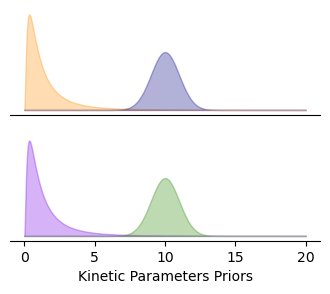

In [129]:
# plot the priors 



numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_validation()
jax.random.PRNGKey(42)
import numpyro.distributions as dist


Sanofi_color = ['#23004C', '#268500', '#7A00E6']
distribution_ = {"k1_f": dist.LogNormal(0, 1), 
                 "E1_f": dist.Normal(10, 1), 
                 "k2_f": dist.LogNormal(0, 1), 
                 "E2_f": dist.Normal(10, 1)
                 }


x = np.linspace(0, 20, 1000)
k1_f_dist = jnp.exp(dist.LogNormal(0, 1).log_prob(x))
k2_f_dist = jnp.exp(dist.LogNormal(0, 1).log_prob(x))
E1_f_dist = jnp.exp(dist.Normal(10, 1).log_prob(x))
E2_f_dist = jnp.exp(dist.Normal(10, 1).log_prob(x))


fig, axs = plt.subplots(2, 1, figsize=(4, 3))


axs[0].fill_between(x, 0, k1_f_dist, color='darkorange', alpha=0.3)
axs[0].fill_between(x, 0, E1_f_dist, color='navy', alpha=0.3)
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)


axs[1].fill_between(x, 0, k1_f_dist, color=Sanofi_color[2], alpha=0.3)
axs[1].fill_between(x, 0, E1_f_dist, color=Sanofi_color[1], alpha=0.3)
axs[1].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[1].set_xlabel('Kinetic Parameters Priors')
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


In [ ]:
def _new_priors3():
    k1_f = numpyro.sample("k1_f", dist.Normal(4.46, 0.02))
    E1_f = numpyro.sample("E1_f", dist.TruncatedNormal(11, 1, low=10, high=11.6)) 
    k2_f = numpyro.sample("k2_f", dist.Normal(6.01,  0.07))
    E2_f = numpyro.sample("E2_f", dist.TruncatedNormal(11, 1, low=10, high=11.6))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

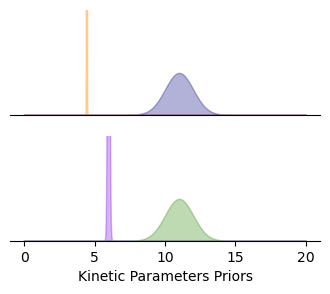

In [144]:
# plot the priors 



numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_validation()
jax.random.PRNGKey(42)
import numpyro.distributions as dist


Sanofi_color = ['#23004C', '#268500', '#7A00E6']
distribution_ = {"k1_f": dist.LogNormal(0, 1), 
                 "E1_f": dist.Normal(10, 1), 
                 "k2_f": dist.LogNormal(0, 1), 
                 "E2_f": dist.Normal(10, 1)
                 }


x = np.linspace(0, 20, 1000)
k1_f_dist = jnp.exp(dist.Normal(4.46, 0.02).log_prob(x))
k2_f_dist = jnp.exp(dist.Normal(6.01,  0.07).log_prob(x))
E1_f_dist = jnp.exp(dist.TruncatedNormal(11, 1).log_prob(x))
E2_f_dist = jnp.exp(dist.TruncatedNormal(11, 1).log_prob(x))


fig, axs = plt.subplots(2, 1, figsize=(4, 3))


axs[0].fill_between(x, 0, k1_f_dist, color='darkorange', alpha=0.3)
axs[0].fill_between(x, 0, E1_f_dist, color='navy', alpha=0.3)
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
axs[0].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[0].set_ylim(0, 1)  # Set y-axis limit to less than 1000


axs[1].fill_between(x, 0, k2_f_dist, color=Sanofi_color[2], alpha=0.3)
axs[1].fill_between(x, 0, E2_f_dist, color=Sanofi_color[1], alpha=0.3)
axs[1].tick_params(axis='y', which='both', left=False, labelleft=False)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel('Kinetic Parameters Priors')
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


In [22]:
# Preparing the experimental data and save them in a 1D array as y_exp_data 
import numpy as np 
SM_measured = []
P_measured = []
IMP_measured = []

for i in range(0, 5):
    SM_measured.append(df_raw.iloc[:, i * 4 + 1])
    P_measured.append(df_raw.iloc[:, i * 4 + 2])
    IMP_measured.append(df_raw.iloc[:, i * 4 + 3])


non_nan_values_SM  = np.concatenate(SM_measured)
non_nan_values_P   = np.concatenate(P_measured)
non_nan_values_IMP = np.concatenate(IMP_measured)


# # Calculate the measured_Y_without_Nan using non-NaN values arrays   
# ******NOTE ******this is where we apply weighting factor
# measured_Y_without_Nan =  non_nan_values_P +  non_nan_values_IMP
measured_Y_without_Nan = 0.9* non_nan_values_P + 0.1*non_nan_values_SM + 0.1*non_nan_values_IMP
nan_mask = jnp.isnan(measured_Y_without_Nan)
y_without_nan = measured_Y_without_Nan[~nan_mask]

# adding noise
noise_level = 0.0001
noise = np.random.normal(0, noise_level, y_without_nan.shape)
y_exp_data = y_without_nan + noise
X_dummy = X_measured
Y_dummy = y_exp_data

In [23]:
out = reaction1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.1,0.9])


5
['SM', 'reagent', 'base', 'IMP1', 'product']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'IMP1': 3, 'product': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'IMP1': 0.1, 'product': 0.9}


In [24]:
X_dummy2 = jnp.concatenate([X_dummy[12:24] ,X_dummy[48:60]])
Y_dummy2 = jnp.concatenate([Y_dummy[12:24] ,Y_dummy[48:60]])

In [25]:

BI_reaction1 = BayesianKineticAI()
BI_model = BI_reaction1.run_bayesian_inference(function = reaction1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors2, 
    X= X_dummy[12:24], 
    Y= Y_dummy[12:24], 
    num_samples=2000,

    num_warmup=1000)

sample: 100%|██████████| 3000/3000 [00:12<00:00, 249.11it/s, 7 steps of size 4.79e-01. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f     10.00      1.00     10.04      8.45     11.72   1558.13      1.00
      E2_f      9.99      0.97      9.96      8.38     11.52   1654.60      1.00
      k1_f      4.40      0.04      4.41      4.35      4.46    702.86      1.00
      k2_f      5.99      0.09      6.00      5.84      6.12    876.76      1.00
     sigma      0.00      0.00      0.00      0.00      0.00    674.27      1.00

Number of divergences: 55


In [44]:
input_new = jnp.concatenate([input_matrix.T, np.zeros((5, 1))], axis=1)
input_new.shape
input_new

time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 540.0, 600.0, 780.0, 900.0, 960.0, 1207.0, 1374.0])


In [45]:
initial_species  = ['SM', 'reagent', 'base']
out_new = reaction1.initilize_ODE_solver_for_numpyro_input(input_new, time, initial_species, [0.1,0,0,0.1,0.9])

5
['SM', 'reagent', 'base', 'IMP1', 'product']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'IMP1': 3, 'product': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'IMP1': 0.1, 'product': 0.9}


In [26]:
y_predicted_all = BI_reaction1.bayesian_inference_predict(BI_model, 
                                        function = reaction1.simulate_symbolic_ode_for_numpyro_C_out,
                                        priors = _new_priors2, 
                                        X= input_new, 
                                        num_samples=2000,
                                        num_warmup=1000)

/var/folders/8m/63t5v3ws3b74sl3bwq5n6sxc0000gn/T/ipykernel_27936/3782322495.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


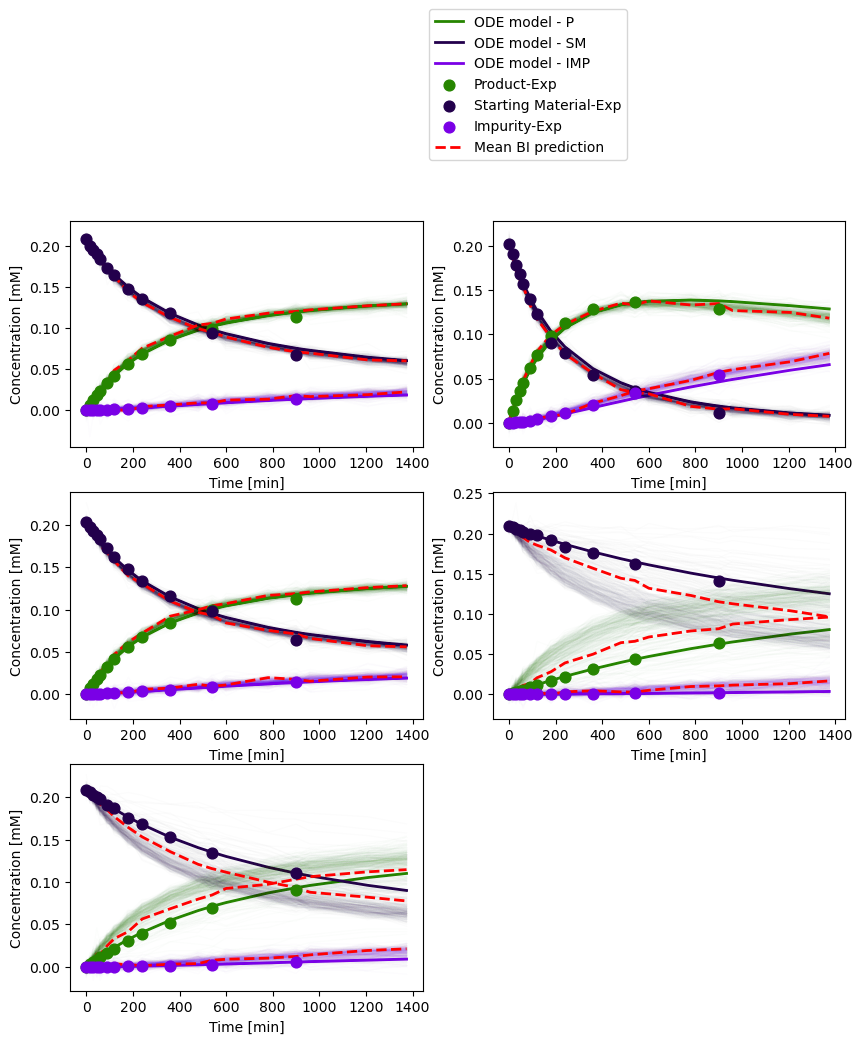

In [27]:
plt.figure(figsize=(10, 10))

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
# for i in range(0, 5):
#     plt.subplot(3, 2, subplot_index)
#     subplot_index += 1
#     for j in range(350):
#         plt.plot(t, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 3], color=Sanofi_color[2], linewidth=1, alpha=0.01)
#     mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(2000)], axis=0)
#     plt.plot(t, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
#     plt.plot(t, mean_predicted[:, 1], color='red', linewidth=2, linestyle='--')
#     plt.plot(t, mean_predicted[:, 3], color='red', linewidth=2, linestyle='--')
#     # plt.legend()

subplot_index_2 = 1
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index_2)
    subplot_index_2 += 1
    plt.plot(time, C_out[:, i, -1], color=Sanofi_color[1], linewidth=2, label='ODE model - P')  
    plt.plot(time, C_out[:, i, 0], color=Sanofi_color[0], linewidth=2, label='ODE model - SM')  
    plt.plot(time, C_out[:, i, -2], color=Sanofi_color[2], linewidth=2, label='ODE model - IMP')  
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 2], label='Product-Exp', s=60, color=Sanofi_color[1],  zorder=10) 
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 1], label='Starting Material-Exp', s=60, color=Sanofi_color[0], zorder=10)    
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 3], label='Impurity-Exp', s=60, color=Sanofi_color[2],  zorder=10)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [mM]')

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index)
    subplot_index += 1
    for j in range(300):
        plt.plot(time, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -2], color=Sanofi_color[2], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
    mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(10000)], axis=0)
    
    plt.plot(time, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
    plt.plot(time, mean_predicted[:, -1], color='red', linewidth=2, linestyle='--')
    plt.plot(time, mean_predicted[:, -2], color='red', linewidth=2, linestyle='--')


    
    if i==4:
        plt.legend(loc='center left', bbox_to_anchor=(1,4))
plt.tight_layout()
plt.show()


/var/folders/8m/63t5v3ws3b74sl3bwq5n6sxc0000gn/T/ipykernel_28571/381261633.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 2, subplot_index)
/var/folders/8m/63t5v3ws3b74sl3bwq5n6sxc0000gn/T/ipykernel_28571/381261633.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


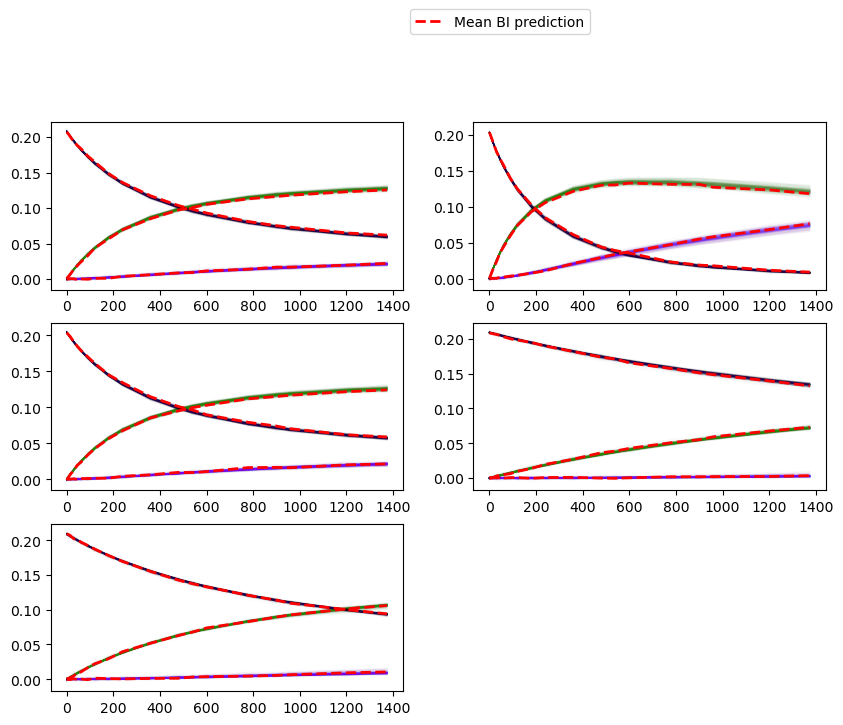

In [150]:
plt.figure(figsize=(10, 10))

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
# for i in range(0, 5):
#     plt.subplot(3, 2, subplot_index)
#     subplot_index += 1
#     for j in range(350):
#         plt.plot(t, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 3], color=Sanofi_color[2], linewidth=1, alpha=0.01)
#     mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(2000)], axis=0)
#     plt.plot(t, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
#     plt.plot(t, mean_predicted[:, 1], color='red', linewidth=2, linestyle='--')
#     plt.plot(t, mean_predicted[:, 3], color='red', linewidth=2, linestyle='--')
#     # plt.legend()

subplot_index_2 = 1
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index_2)
    subplot_index_2 += 1
    plt.plot(time, C_out[:, i, -1], color=Sanofi_color[1], linewidth=2, label='ODE model - P')  
    plt.plot(time, C_out[:, i, 0], color=Sanofi_color[0], linewidth=2, label='ODE model - SM')  
    plt.plot(time, C_out[:, i, -2], color=Sanofi_color[2], linewidth=2, label='ODE model - IMP')  
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 2], label='Product-Exp', s=60, color=Sanofi_color[1],  zorder=10) 
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 1], label='Starting Material-Exp', s=60, color=Sanofi_color[0], zorder=10)    
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 3], label='Impurity-Exp', s=60, color=Sanofi_color[2],  zorder=10)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [mM]')

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
for i in range(0, 5):
    plt.subplot(4, 2, subplot_index)
    subplot_index += 1
    for j in range(300):
        plt.plot(time, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -2], color=Sanofi_color[2], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
    mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(10000)], axis=0)
    
    plt.plot(time, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
    plt.plot(time, mean_predicted[:, -1], color='red', linewidth=2, linestyle='--')
    plt.plot(time, mean_predicted[:, -2], color='red', linewidth=2, linestyle='--')


    
    if i==4:
        plt.legend(loc='center left', bbox_to_anchor=(1,4))
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


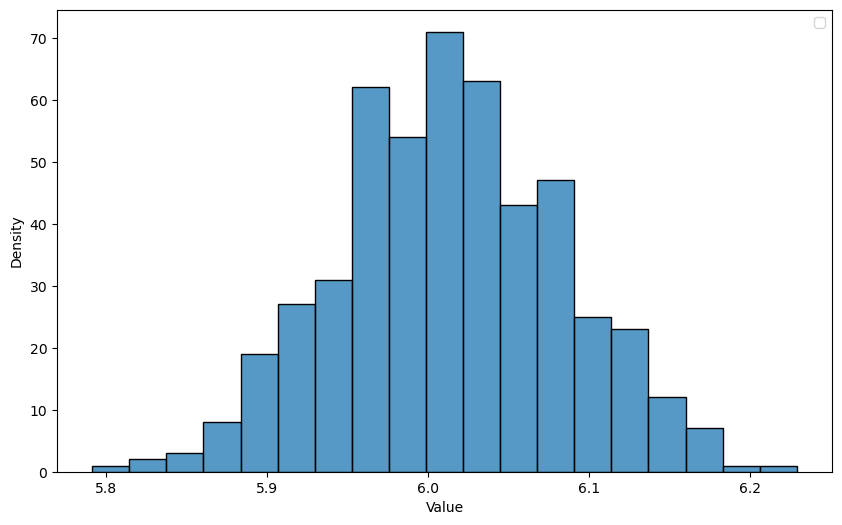

In [31]:
# sample: 100%|██████████| 3000/3000 [00:13<00:00, 225.12it/s, 5 steps of size 4.86e-01. acc. prob=0.88] 

#                 mean       std    median      5.0%     95.0%     n_eff     r_hat
#       E1_f      9.97      0.98      9.97      8.38     11.55   1813.24      1.00
#       E2_f     10.00      0.95     10.00      8.56     11.62   1978.75      1.00
#       k1_f      4.40      0.04      4.41      4.34      4.46    723.92      1.00
#       k2_f      5.99      0.09      5.99      5.85      6.14    627.98      1.00
#      sigma      0.00      0.00      0.00      0.00      0.00    667.37      1.00

numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")
numpyro.enable_validation()
jax.random.PRNGKey(42)
mu = 0
sigma = 1


# Generate samples from the LogNormal distribution
distribution_ = dist.Normal(4.40, 0.04)
distribution_ = dist.Normal(5.99,  0.09)

# distribution_ = dist.TruncatedNormal(11, 1, low=10, high=11.6)
# # distribution_  = dist.LogNormal(2.3, 0.1).expand_by([1]).to_event(1).mask(False)
num_samples = 500
# Sample from the distribution
samples =  distribution_.sample(jax.random.PRNGKey(123), (num_samples,))


fig = plt.figure(figsize=(10, 6))
sns.histplot(samples)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [26]:
def _new_priors3():
    k1_f = numpyro.sample("k1_f", dist.Normal(4.40, 0.04))
    E1_f = numpyro.sample("E1_f", dist.Normal(10, 1)) 
    k2_f = numpyro.sample("k2_f", dist.Normal(5.99,  0.09))
    E2_f = numpyro.sample("E2_f", dist.Normal(10, 1))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

In [29]:
def _new_priors3():
    k1_f = numpyro.sample("k1_f", dist.Normal(4.46, 0.02))
    E1_f = numpyro.sample("E1_f", dist.TruncatedNormal(11, 1, low=10, high=11.6)) 
    k2_f = numpyro.sample("k2_f", dist.Normal(6.01,  0.07))
    E2_f = numpyro.sample("E2_f", dist.TruncatedNormal(11, 1, low=10, high=11.6))
    return {"k1_f": k1_f,
            "E1_f": E1_f,
            "k2_f": k2_f,
            "E2_f": E2_f}

In [36]:
initial_species  = ['SM', 'reagent', 'base']
out_new = reaction1.initilize_ODE_solver_for_numpyro_input(X_dummy, t, initial_species, [0.1,0,0,0.1,0.9])

5
['SM', 'reagent', 'base', 'IMP1', 'product']
The list of indices used to solve the ODE system is: {'SM': 0, 'reagent': 1, 'base': 2, 'IMP1': 3, 'product': 4}
Acq function weights: {'SM': 0.1, 'reagent': 0, 'base': 0, 'IMP1': 0.1, 'product': 0.9}


In [37]:

BI_reaction1_new = BayesianKineticAI()
BI_model = BI_reaction1_new.run_bayesian_inference(function = reaction1.simulate_symbolic_ode_for_numpyro,
    priors = _new_priors3, 
    X= X_dummy[48:], 
    Y= Y_dummy[48:], 
    num_samples=2000,

    num_warmup=1000)

sample: 100%|██████████| 3000/3000 [00:15<00:00, 189.52it/s, 31 steps of size 8.31e-02. acc. prob=0.85]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      E1_f     11.30      0.03     11.31     11.26     11.35    198.49      1.00
      E2_f     11.42      0.19     11.48     11.18     11.60    277.38      1.00
      k1_f      4.46      0.02      4.46      4.42      4.49    217.61      1.01
      k2_f      6.03      0.07      6.03      5.92      6.15    173.07      1.00
     sigma      0.00      0.00      0.00      0.00      0.00    146.68      1.00

Number of divergences: 1522


In [46]:
# run plots again 

y_predicted_all = BI_reaction1_new.bayesian_inference_predict(BI_model, 
                                        function = reaction1.simulate_symbolic_ode_for_numpyro_C_out,
                                        priors = _new_priors3, 
                                        X= input_new, 
                                        num_samples=2000,
                                        num_warmup=1000)

/var/folders/8m/63t5v3ws3b74sl3bwq5n6sxc0000gn/T/ipykernel_28571/3782322495.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


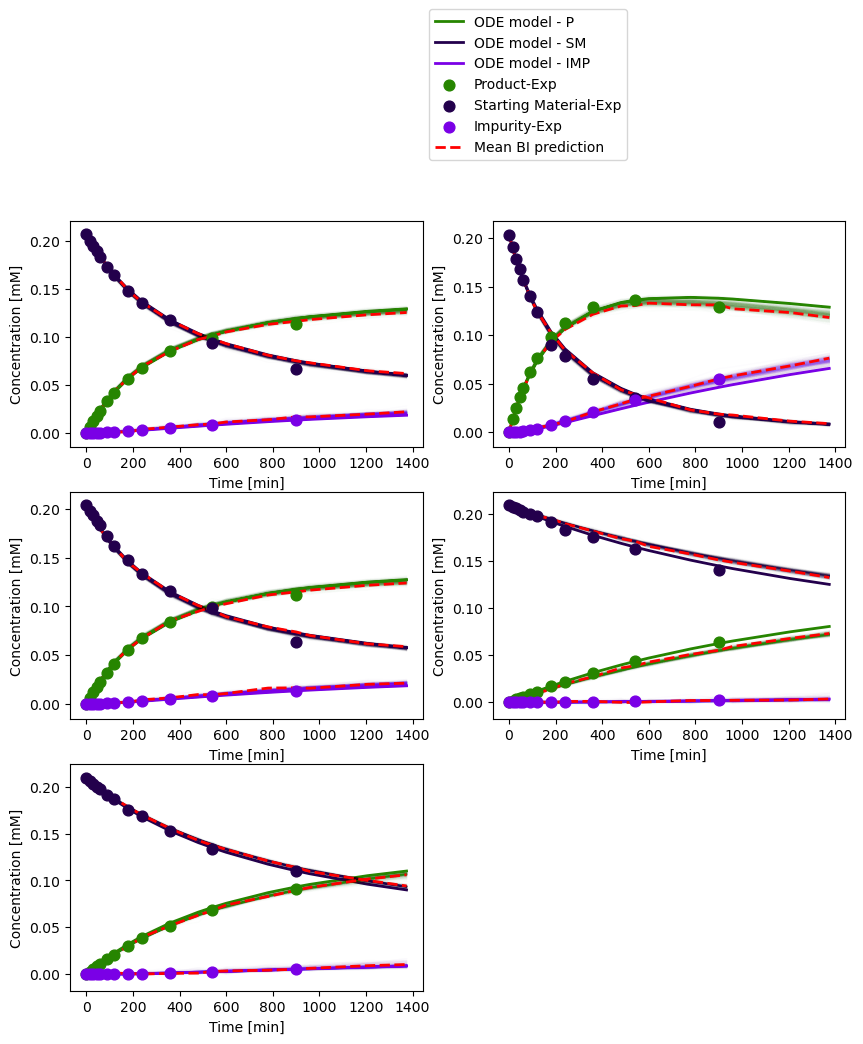

In [47]:
plt.figure(figsize=(10, 10))

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
# for i in range(0, 5):
#     plt.subplot(3, 2, subplot_index)
#     subplot_index += 1
#     for j in range(350):
#         plt.plot(t, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
#         plt.plot(t, y_predicted_all[j][:, i, 3], color=Sanofi_color[2], linewidth=1, alpha=0.01)
#     mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(2000)], axis=0)
#     plt.plot(t, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
#     plt.plot(t, mean_predicted[:, 1], color='red', linewidth=2, linestyle='--')
#     plt.plot(t, mean_predicted[:, 3], color='red', linewidth=2, linestyle='--')
#     # plt.legend()

subplot_index_2 = 1
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index_2)
    subplot_index_2 += 1
    plt.plot(time, C_out[:, i, -1], color=Sanofi_color[1], linewidth=2, label='ODE model - P')  
    plt.plot(time, C_out[:, i, 0], color=Sanofi_color[0], linewidth=2, label='ODE model - SM')  
    plt.plot(time, C_out[:, i, -2], color=Sanofi_color[2], linewidth=2, label='ODE model - IMP')  
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 2], label='Product-Exp', s=60, color=Sanofi_color[1],  zorder=10) 
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 1], label='Starting Material-Exp', s=60, color=Sanofi_color[0], zorder=10)    
    plt.scatter(df_raw.iloc[:, i * 4], df_raw.iloc[:, i * 4 + 3], label='Impurity-Exp', s=60, color=Sanofi_color[2],  zorder=10)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [mM]')

subplot_index = 1
Sanofi_color = ['#23004C', '#268500', '#7A00E6']
for i in range(0, 5):
    plt.subplot(3, 2, subplot_index)
    subplot_index += 1
    for j in range(300):
        plt.plot(time, y_predicted_all[j][:, i, 0], color=Sanofi_color[0], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -2], color=Sanofi_color[2], linewidth=1, alpha=0.01)
        plt.plot(time, y_predicted_all[j][:, i, -1], color=Sanofi_color[1], linewidth=1, alpha=0.01)
    mean_predicted = np.mean([y_predicted_all[j][:, i] for j in range(10000)], axis=0)
    
    plt.plot(time, mean_predicted[:, 0], color='red', linewidth=2, linestyle='--', label='Mean BI prediction')
    plt.plot(time, mean_predicted[:, -1], color='red', linewidth=2, linestyle='--')
    plt.plot(time, mean_predicted[:, -2], color='red', linewidth=2, linestyle='--')


    
    if i==4:
        plt.legend(loc='center left', bbox_to_anchor=(1,4))
plt.tight_layout()
plt.show()


In [48]:
#plot ODE solver
 
# define the initial conditions

                 # T  SM_0   R_0   B_0 
X1 = jnp.array([81.9, 0.208, 0.2, 0.405])
X2 = jnp.array([81.9, 0.203, 0.4, 0.405])
X3 = jnp.array([81.9, 0.204, 0.2, 0.811])
X4 = jnp.array([61.1, 0.209, 0.2, 0.406])
X5 = jnp.array([71.0, 0.209, 0.2, 0.407])

X1 = jnp.reshape(X1, (4, 1))
X2 = jnp.reshape(X2, (4, 1))
X3 = jnp.reshape(X3, (4, 1))
X4 = jnp.reshape(X4, (4, 1))
X5 = jnp.reshape(X5, (4, 1))

input_matrix = jnp.concatenate([X1, X2, X3, X4, X5], axis=1)

# time = jnp.array([0.0, 30.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 600.0, 780.0, 960.0, 1207.0, 1374.0])
time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0, 480.0, 540.0, 600.0, 780.0, 900.0, 960.0, 1207.0, 1374.0])

# time = jnp.array([0.0, 15.0, 30.0, 45.0, 60.0, 90.0, 120.0, 180.0, 240.0, 360.0,  540.0,  900.0])



ground_truth_params = {
"k1_f": 0.011,
"E1_f": 70.2E3,
"k2_f": 0.002,
"E2_f": 78.92E3,
}

mean_params = {
"k1_f": jnp.exp(-4.50),
"E1_f": jnp.exp(11.15),
"k2_f": jnp.exp(-6.20),
"E2_f": jnp.exp(11.27),
}


df_raw = pd.read_csv("example_2_experimental_data2.csv", engine='python')
C_out, names = reaction2.simulate_symbolic_ode_(input_matrix.T, ground_truth_params, time, initial_species=['SM','reagent','base'])


['SM', 'reagent', 'base', 'product', 'IMP2']


In [25]:
# get samples and plot the Posterior Distributions

import corner
import arviz as az
from pyro.infer import MCMC, NUTS
hmc_samples = BI_model.get_samples().items()

In [26]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples:
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: E1_f
        mean       std         5%        25%        50%       75%        95%
0  10.837098  0.440674  10.119839  10.471751  10.851349  11.21015  11.517149 

Site: E2_f
        mean       std         5%        25%        50%        75%        95%
0  10.840728  0.440389  10.113986  10.479431  10.861339  11.212964  11.515554 

Site: k1_f
       mean      std        5%       25%       50%       75%       95%
0  4.456592  0.02212  4.420168  4.442561  4.456954  4.470536  4.492747 

Site: k2_f
       mean       std        5%       25%       50%       75%       95%
0  6.033172  0.065926  5.928505  5.990494  6.031709  6.074008  6.141378 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.003047  0.000583  0.002274  0.002637  0.002965  0.003362  0.004106 



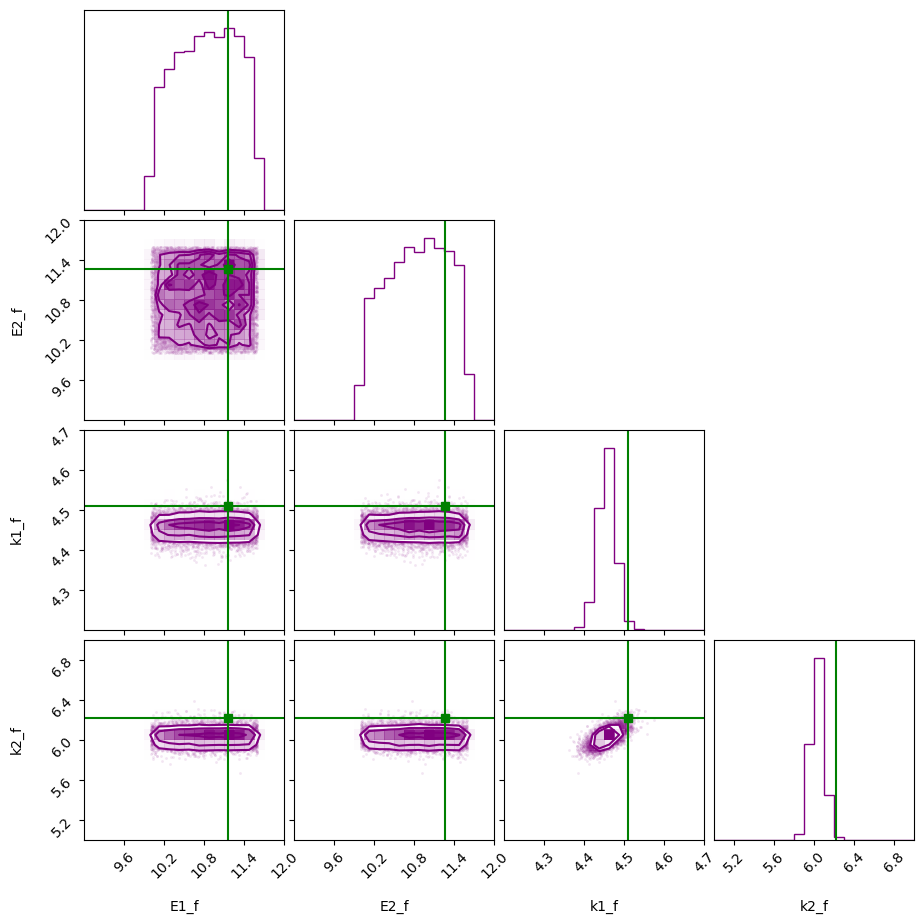

In [35]:
import numpy as np
import corner

hmc_samples_array = np.array([hmc_samples_dict[var_name] for var_name in ["E1_f", "E2_f", "k1_f", "k2_f"]]).T

ground_truth_array = np.array([ground_truth_params_log[var_name] for var_name in ["E1_f", "E2_f", "k1_f", "k2_f"]])

figure = corner.corner(
    hmc_samples_array,
    labels=["E1_f", "E2_f", "k1_f", "k2_f"],
    range=[(9,12), (9, 12), (4.2, 4.7), (5, 7)], 
    color='purple',
    truths=ground_truth_array,
    truth_color="Green"
)
# figure = corner.corner(
#     hmc_samples_array,
#     labels=["E1_f", "E2_f", "k1_f", "k2_f"],
#     color='purple',
#     truths=ground_truth_array,
#     truth_color="Green"
# )
# figure.show()
